In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import xarray as xr
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, places
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import math
from scipy import io
import pickle
import cmocean
from salishsea_tools import Keegan_eval_tools as ket
import json
from collections import OrderedDict
from matplotlib.colors import LogNorm
import arrow
import glob
import datetime
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib.dates import HourLocator, MonthLocator, YearLocator

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [2]:
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/mesh_mask202108.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

## Bring in grid coordinates for slice/box of interest

In [3]:
ii, ij = 300,365
ji, jj = 50, 100



In [4]:
JdF = [300,365,50, 100]

In [5]:
yearList = [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]

data = 'month-avg.202111'
#year = '2014'
month = '01'
file = 'biol'

for year in yearList:
    files=[glob.glob(f'/results2/SalishSea/{data}/SalishSeaCast_1m_{file}_T_*{year}*{month:02d}01_*{year}*{month:02d}??.nc')[0] for year in yearList for month in range(1,13) ]
    

In [6]:
## Gathering metadata but still not opening the files
dsfiles = xr.open_mfdataset(
        files,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['ammonium', 'silicon', \
                        'dissolved_organic_nitrogen', \
                        'particulate_organic_nitrogen', 'biogenic_silicon'],
        parallel=True,
        engine='netcdf4'
    )

In [7]:
np.shape(JdF)

(4,)

In [8]:
np.shape(dsfiles.time)

(192,)

In [9]:
dsfiles.diatoms

<xarray.DataArray 'diatoms' (time: 192, depth: 40, gridY: 898, gridX: 398)>
dask.array<concatenate, shape=(192, 40, 898, 398), dtype=float32, chunksize=(1, 40, 898, 398), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2007-01-15T12:00:00 ... 2022-12-15T12:00:00
  * depth    (depth) float32 0.5 1.5 2.5 3.5 4.5 ... 360.7 387.6 414.5 441.5
  * gridY    (gridY) int64 0 1 2 3 4 5 6 7 8 ... 890 891 892 893 894 895 896 897
  * gridX    (gridX) int64 0 1 2 3 4 5 6 7 8 ... 390 391 392 393 394 395 396 397
Attributes:
    standard_name:  mole_concentration_of_diatoms_expressed_as_nitrogen_in_se...
    long_name:      Diatoms Concentration
    units:          mmol m-3

In [10]:
np.shape(tmask) 

(40, 898, 398)

In [11]:
## tmask has no time so we need to broadcast_to 192 (12 x # of years in time series)

In [12]:
newmask=np.broadcast_to(tmask[:,JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]],(192,40,65,50))

In [13]:
np.shape(newmask) 

(192, 40, 65, 50)

In [14]:
tt=np.array(dsfiles.time)
mod_depth=np.array(dsfiles.depth)
mod_diatoms=(dsfiles.diatoms[:,:, JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]])
mod_diatoms = (np.array(mod_diatoms))

mod_diatoms = np.ma.masked_where(newmask==0,mod_diatoms) ## masking where there is land

In [15]:
mod_diatoms = mod_diatoms.T ## transpose the variable to make it work with the Hovmoller plots

In [16]:
np.shape(mod_diatoms)

(50, 65, 40, 192)

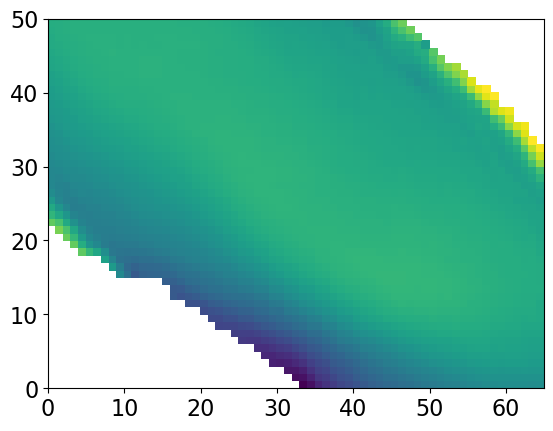

In [17]:
## Check to see what is there

plt.pcolormesh(mod_diatoms[:,:,0,0]) ## viewing the first depth at the first time stamp; remember z and t are the last two axes here


## Dataset for climatology

In [18]:
clim=nc.Dataset('/results2/SalishSea/month-avg.202111/SalishSeaCast_month_climatology_biol_T_20070101_20230831.nc')

In [19]:
clim.variables.keys()

dict_keys(['nitrate', 'ammonium', 'silicon', 'diatoms', 'flagellates', 'microzooplankton', 'dissolved_organic_nitrogen', 'particulate_organic_nitrogen', 'biogenic_silicon', 'mesozooplankton', 'depth', 'gridY', 'gridX', 'month'])

In [20]:
climmask=np.broadcast_to(tmask[:,JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]],(12,40,65,50)) ## mask for climatology files

In [21]:
clim=np.ma.masked_where(climmask==0,clim['diatoms'][:,:, JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]])

In [22]:
## Designate date_range for Hovmoller plots

start= dt.datetime(2007,1,1)
end=dt.datetime(2022,12,31)

In [23]:
date_range=(start,end)

In [24]:
np.shape(mod_diatoms)

(50, 65, 40, 192)

In [25]:
mod_diatoms_mean=np.mean(mod_diatoms, axis=(0, 1)) ## calculate the mean across the entire slice/box 4d to 2d array

In [26]:
mod_diatoms_mean.max()

3.5148022894323225

/ocean/ksuchy/MOAD/tools/SalishSeaTools/salishsea_tools/Keegan_eval_tools.py:816: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis="x", nbins=20)


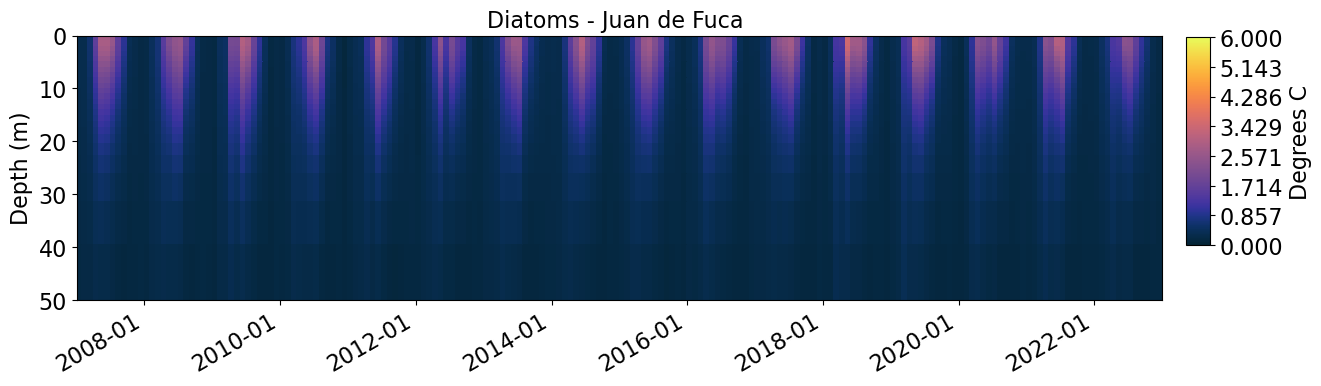

In [27]:

ax=ket.hovmoeller(mod_diatoms_mean[:,:], mod_depth, tt,(0,50),date_range, title='Diatoms - Juan de Fuca ',
               var_title='Degrees C',vmax=0,vmin=6,cmap=cmo.cm.thermal)



ax.set_ylabel('Depth (m)')
ax.set_xlabel('')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))



In [28]:
np.shape(mod_diatoms_mean)

(40, 192)

In [29]:
np.shape(clim)

(12, 40, 65, 50)

In [30]:
clim_mean=np.mean(clim, axis=(2, 3)) ## Now have to calculate climatology mean across the entire slice/box 4d to 2d array

In [31]:
np.shape(clim_mean) ## climatology is only for 12 months

(12, 40)

In [32]:
### This isn't pretty, but I could not figure out how to repeat the climatology for all years in the time series
### np.repeat did not repeat on the proper axes

year1=clim_mean[:,:] #.swapaxes(1,0)
year2=clim_mean[:,:] #.swapaxes(1,0)                
year3=clim_mean[:,:] #.swapaxes(1,0)                
year4=clim_mean[:,:] #.swapaxes(1,0)                
year5=clim_mean[:,:] #.swapaxes(1,0)                
year6=clim_mean[:,:] #.swapaxes(1,0)  
year7=clim_mean[:,:] #.swapaxes(1,0)
year8=clim_mean[:,:] #.swapaxes(1,0)
year9=clim_mean[:,:] #.swapaxes(1,0)
year10=clim_mean[:,:] #.swapaxes(1,0)
year11=clim_mean[:,:] #.swapaxes(1,0)
year12=clim_mean[:,:] #.swapaxes(1,0)
year13=clim_mean[:,:] #.swapaxes(1,0)
year14=clim_mean[:,:] #.swapaxes(1,0)
year15=clim_mean[:,:] #.swapaxes(1,0)
year16=clim_mean[:,:] #.swapaxes(1,0)                

In [33]:
np.shape(year1)

(12, 40)

In [34]:
## Concatentate all of the above files to get sequential climatologies across the time series
clim_diatoms=np.concatenate((year1,year2,year3,year4,year5,year6, year7, year8,year9,year10,\
                         year11,year12,year13,year14,year15,year16), axis=0)

In [35]:
np.shape(clim_diatoms)

(192, 40)

In [36]:
clim_diatoms=clim_diatoms.T ## Transpose to match with the other variable

In [37]:
np.shape(clim_diatoms)

(40, 192)

In [38]:
(mod_diatoms_mean-clim_diatoms).min()

-1.2994888576530141

In [39]:
(mod_diatoms_mean[:,:]-clim_diatoms[:,:]).max()

1.1779557628744453

In [40]:
clim_diatoms

masked_array(
  data=[[0.26587738, 0.40339318, 0.78928497, ..., 0.47327504, 0.27705419,
         0.24174019],
        [0.26661312, 0.4042771 , 0.78950374, ..., 0.47281119, 0.27752889,
         0.24214728],
        [0.26651498, 0.40330483, 0.78030928, ..., 0.4639401 , 0.27644118,
         0.24192765],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]],
  mask=False,
  fill_value=1e+20)

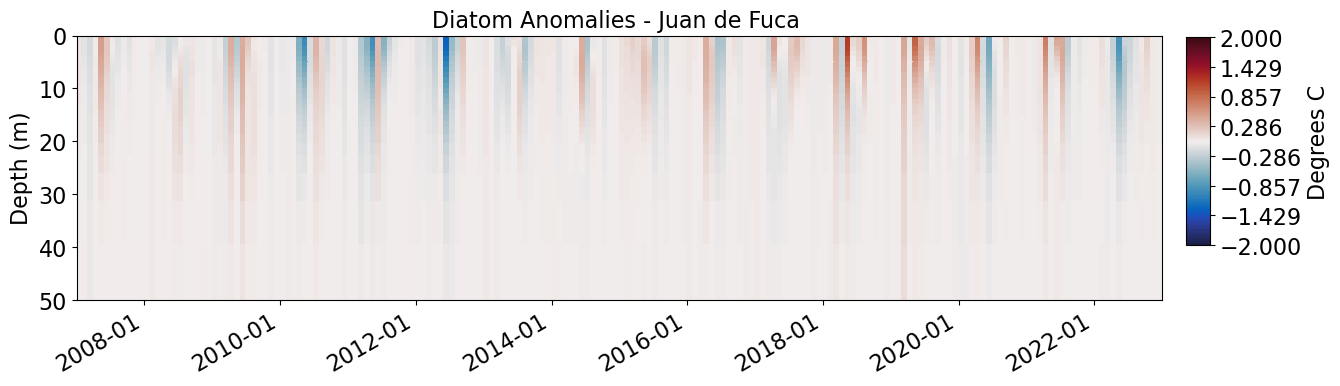

In [41]:
ax=ket.hovmoeller(mod_diatoms_mean-clim_diatoms, mod_depth, tt,(0,50),date_range, title='Diatom Anomalies - Juan de Fuca ',
               var_title='Degrees C',vmax=-2,vmin=2,cmap=cmo.cm.balance)



ax.set_ylabel('Depth (m)')
ax.set_xlabel('')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


#contour_value = 9 
#contour = ax.contour(tt, mod_depth, mod_diatoms, levels=[contour_value], colors='mediumslateblue')

## Calculate anomalies across specific depth ranges

In [42]:
mean_anomalies=np.mean(mod_diatoms_mean-clim_diatoms,axis=0) ## All depths

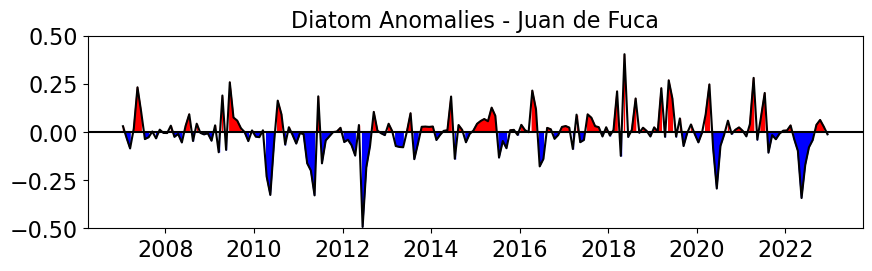

In [43]:
### All depths 

fig,ax=plt.subplots(1,1,figsize=(10,2.5))
x=tt
y=mean_anomalies

ax.plot(x,y,color='k')
ax.set_ylim(-.5,.5)
ax.axhline(y=0,color='k',linestyle='-')

ax.fill_between(x,y,where=y<0, color='blue')
ax.fill_between(x,y,where=y>0, color='red')

ax.set_title('Diatom Anomalies - Juan de Fuca')

plt.show()

In [44]:
mean_anomalies_surf=np.mean(mod_diatoms_mean[0:23]-clim_diatoms[0:23],axis=0) ##20 = 25m depth

In [45]:
np.shape(mean_anomalies_surf)

(192,)

In [46]:
np.shape(tt)

(192,)

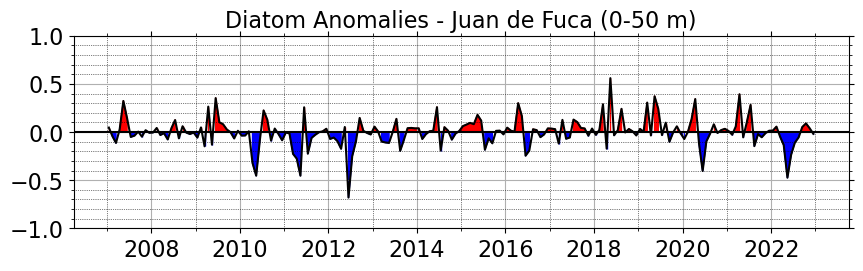

In [47]:
## mean anomalies for surface (0-50m) only

fig,ax=plt.subplots(1,1,figsize=(10,2.5))
x=tt
y=mean_anomalies_surf


ax.plot(x,y,color='k')
ax.set_ylim(-1,1)
plt.grid(True)
ax.minorticks_on()
#plt.grid(which='major',axis ='y', linewidth='1', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.tick_params(which='both', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='off') # turn off bottom ticks
hloc = YearLocator(1)
ax.xaxis.set_minor_locator(hloc)

ax.axhline(y=0,color='k',linestyle='-')


ax.fill_between(x,y,where=y<0, color='blue')
ax.fill_between(x,y,where=y>0, color='red')

ax.set_title('Diatom Anomalies - Juan de Fuca (0-50 m)')
#plt.grid()
plt.show()

In [48]:
dsfiles.close()